In [63]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPool2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, ELU
from keras.layers import Conv2D, LSTM, BatchNormalization, MaxPool2D, Reshape
from keras.utils import to_categorical
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [65]:
# cd drive/MyDrive/'Colab Notebooks'/CNN_Project/

(2115, 22, 1000)


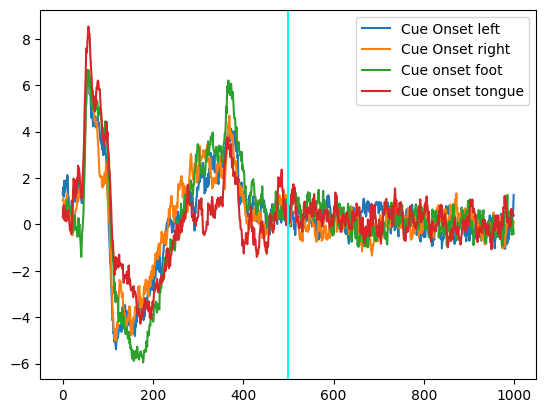

In [66]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# 2115 trials with each trial being a 22 x 1000 dimension data point
# Try to classify each movement by it's type/label (0, 1, 2, 3 - left, right, foot, tongue)
# Cue onset arm left - 0
# Cue onset arm right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

# Plotted for channel 8 of 22 channels
ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])




# Only using first 500 timesteps because from the chart we can see everything to the right
# of 500 looks like noise, while the left looks like better information
# Can also keep all 1000 if you want (optional preprocessing step)
# Too long of a time duration can be too much for RNN/LSTM, so it helps to reduce time duration

In [67]:
indices = np.where(person_train_valid == 0.0)[0]

subject_0_X_train_data = X_train_valid[indices]
subject_0_y_train_data = y_train_valid[indices]

print ('Training/Valid data shape: {}'.format(subject_0_X_train_data.shape))
print ('Training/Valid data shape: {}'.format(subject_0_y_train_data.shape))

Training/Valid data shape: (237, 22, 1000)
Training/Valid data shape: (237,)


In [68]:
## Preprocessing the dataset
# ONLY TAKING FIRST 500 datapoints of the 1000
X_train_valid_prep = subject_0_X_train_data[:,:,0:500]
X_test_prep = X_test[:,:,0:500]

print(X_train_valid_prep.shape)
print(subject_0_y_train_data.shape)
print(X_test_prep.shape)
print(y_test.shape)

(237, 22, 500)
(237,)
(443, 22, 500)
(443,)


In [69]:
# 100 for validation, rest for training
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(237, 100, replace=False)
ind_train = np.array(list(set(range(237)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (137, 22, 500)
Shape of validation set: (100, 22, 500)
Shape of training labels: (137,)
Shape of validation labels: (100,)
Shape of training labels after categorical conversion: (137, 4)
Shape of validation labels after categorical conversion: (100, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (137, 22, 500, 1)
Shape of validation set after adding width info: (100, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (137, 500, 1, 22)
Shape of validation set after dimension reshaping: (100, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


In [70]:
# Building the CNN model using sequential class
# Building the layers of the CNN model is the sequential package
# Initialize cnn model using sequential block
# MODEL ARCHITECTURE
basic_cnn_model = Sequential()

# First layer requires the shape of the input
# Can you relu activation instead of relu
# Block is being repeated 4 times, but with filter size increase with each layer

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(5,5), kernel_regularizer=L1L2(l1=0.0, l2=0.15), padding='same', activation='elu', input_shape=(500,1,22)))
basic_cnn_model.add(MaxPool2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(5,5), kernel_regularizer=L1L2(l1=0.0, l2=0.15), padding='same', activation='elu'))
basic_cnn_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(5,5), kernel_regularizer=L1L2(l1=0.0, l2=0.15), padding='same', activation='elu'))
basic_cnn_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(5,5), kernel_regularizer=L1L2(l1=0.0, l2=0.15), padding='same', activation='elu'))
basic_cnn_model.add(MaxPool2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.6))


# Full-connected layer with 4 units and softmax activation to obtain probabilities
# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, kernel_regularizer=L1L2(l1=0.0, l2=0.15), activation='softmax')) # Output FC layer with softmax activation

# kernel_regularizer=L1L2(l1=0, l2=0.02)
# Printing the model summary
basic_cnn_model.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 500, 1, 25)        13775     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 167, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_20 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 167, 1, 50)        31300     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 56, 1, 50)        

In [71]:
# Model parameters MODEL PARAMETERS
learning_rate = 0.0009
epochs = 100
cnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay = 0.001)

In [72]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# # Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             verbose=True)



Epoch 1/100
3/3 [==============================] - 1s 106ms/step - loss: 41.1601 - accuracy: 0.2409 - val_loss: 34.5604 - val_accuracy: 0.2300
Epoch 2/100
3/3 [==============================] - 0s 65ms/step - loss: 34.4854 - accuracy: 0.2409 - val_loss: 29.1466 - val_accuracy: 0.2000
Epoch 3/100
3/3 [==============================] - 0s 63ms/step - loss: 28.9688 - accuracy: 0.3139 - val_loss: 24.7629 - val_accuracy: 0.2000
Epoch 4/100
3/3 [==============================] - 0s 66ms/step - loss: 24.9368 - accuracy: 0.3139 - val_loss: 21.2759 - val_accuracy: 0.2700
Epoch 5/100
3/3 [==============================] - 0s 62ms/step - loss: 21.5715 - accuracy: 0.2993 - val_loss: 18.5569 - val_accuracy: 0.2700
Epoch 6/100
3/3 [==============================] - 0s 65ms/step - loss: 19.2026 - accuracy: 0.2847 - val_loss: 16.4601 - val_accuracy: 0.3200
Epoch 7/100
3/3 [==============================] - 0s 65ms/step - loss: 16.7646 - accuracy: 0.4015 - val_loss: 14.8667 - val_accuracy: 0.3100
Epoch

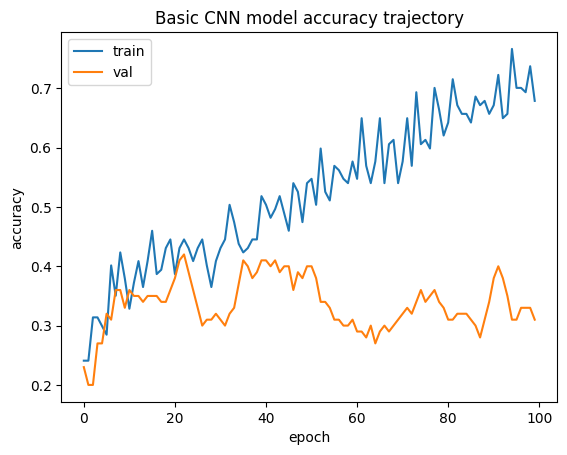

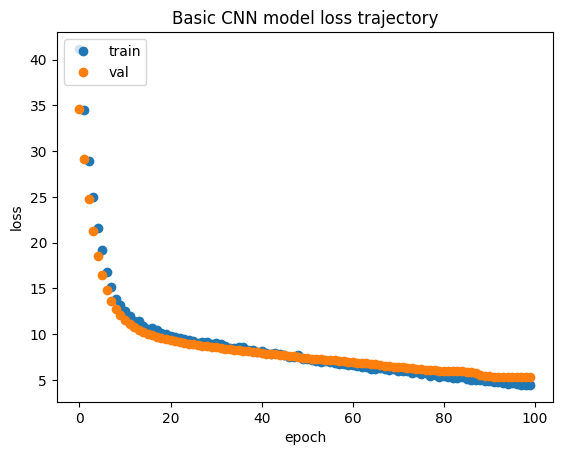

In [73]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
## Testing the basic CNN model - using the model from the last epoch (Must get 70% or higher for full credit)

cnn_score_subject_0 = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score_subject_0[1])

Test accuracy of the basic CNN model: 0.31828442215919495


In [75]:
# Save Model
import pickle

filename = 'CNN_Subject_0.sav'
pickle.dump(basic_cnn_model, open(filename, 'wb'))

In [76]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x_test, y_test, verbose=0)
print(result[1])

0.31828442215919495


This is a reasonabley well performing model, the validation accuracy (orange) is closely following the training accuracy (blue), so the model is not overfitting. Similar for the loss plot, the validation(orange) is following closely with the training loss (blue) and seems to be converging (going toward zero), may be better to train for more epochs to see further convergence.

U shaped curve for the loss means we are overfitting.